# Continued from Milestone 1
## Step 2: Let's Dive into the dataset! (Initial Observations, Data cleaning, and general prep work)
### Initial observation through profile reports
The two `.html` files in the `analysis` folder are profile reports generated through the `pandas_profiling` module, which allows us to see a detailed description of the data and some preliminary statistics and metadata about the data as well. This will help us identify what types of values there are, and what values we need to clean up!

The Profiling Report file for each dataframe was created using the following code:

`pr = pprof.ProfileReport(ratings_df)
pr.to_file(output_file='ratings_profiling_report.html')
pr = pprof.ProfileReport(anime_df)
pr.to_file(output_file='anime_profiling_report.html')`

**NOTE:** *This is not included in the notebook since the files are quite large (around 100MB), and running this profiling locally each time would take too much time.*

### Data Cleanup
We already have python methods that will load and clean/process the data for us in the `scripts` folder, so let's use that to help us prep the data! 

Sadly, I couldn't figure out how to do the relative imports like everyone else on Piazza so here's me trying and failing:

![fail](../images/ImportError.png)

I've left the folders and everything intact so it proves I tried. For this analysis instead I'll just run these methods locally in the notebook...
Here's the file contents:

**NOTE**: Since MyAnimeList orders their anime's genres in alphabetical order, the ones starting with the first few letters of the alphabet will always be preferred, leading to skewed data. Since it then becomes hard to distinguish or classify any one anime into a main/sub-genre format, I decided to shuffle the list of genres upon loading, so it will be randomized every time the data is loaded/processed. It is hard to classify an anime into one single genre, since usually they are the sum of their parts and not just one/two genres. Instead of going through all 11,000 anime and deciding the main and subgenre, I have elected to use this solution. It isn't the best solution, but for our analysis purposes it ensures that atleast we won't *always* have skewed data. Thank you for understanding.

Okay! Now we can finally load and use the data!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import csv
import warnings
import random
from scripts.project_functions import *
warnings.filterwarnings("ignore")

#Seaborn Settings
sns.set_theme(style = 'ticks', font_scale = 2)

In [9]:
anime_df = load_and_process_anime('../data/raw/anime.csv')
anime_df

,anime_id,name,genre,type,episodes,rating
0,1,Cowboy Bebop,"[ Sci-Fi, Action, Space, Comedy, Adventure,...",TV,26,8.82
1,5,Cowboy Bebop: Tengoku no Tobira,"[ Mystery, Space, Action, Sci-Fi, Drama]",Movie,1,8.40
2,6,Trigun,"[ Comedy, Sci-Fi, Action]",TV,26,8.32
3,7,Witch Hunter Robin,"[ Magic, Action, Mystery, Supernatural, Pol...",TV,26,7.36
4,8,Beet the Vandel Buster,"[ Supernatural, Fantasy, Shounen, Adventure]",TV,52,7.06
...,...,...,...,...,...,...
11040,34476,Platonic Chain: Ansatsu Jikkouchuu,"[Sci-Fi, Slice of Life]",Special,1,1.67
11041,34490,Sushi Azarashi,[Comedy],TV,30,3.00
11042,34503,Kochinpa! Dainiki,[Comedy],TV,24,3.40
11043,34514,Pokemon Generations,"[ Kids, Adventure, Fantasy, Action, Game]",ONA,18,7.21


In [10]:
id_set = set(anime_df['anime_id'].tolist()) #Create a list of all the anime that are still in the anime dataset for filtering
ratings_df = load_and_process_ratings('../data/raw/rating.csv', id_set)
ratings_df

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10
...,...,...,...
6294160,73515,16512,7
6294161,73515,17187,9
6294162,73515,22145,10
6294163,73516,790,9


## Step 3: Quick and Dirty Exploratory Data Analysis

Okay, now our data has been prepped, lets do a quick and simple EDA to gauge the relationships and show us things on levels that we couldn't see in the profile report.

First up, What does our dataset look like, in terms of variables, size, shape and some preliminary stats.

In [11]:
print('Anime Database: ' + str(anime_df.shape))
print('Ratings Database: ' + str(ratings_df.shape))

Anime Database: (11045, 6)
Ratings Database: (6294165, 3)


In [12]:
anime_df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes      int64
rating      float64
dtype: object

In [13]:
ratings_df.dtypes

user_id     int64
anime_id    int64
rating      int64
dtype: object


After cleanup, there is info on around 11,000 anime, and 6.2 million user ratings for those anime (WOW that's a lot... no wonder this file is like 100MB).

How is the spread of data then?

In [16]:
anime_df.describe().drop(columns=['anime_id']).T

,count,mean,std,min,25%,50%,75%,max
episodes,11045.0,13.229153,48.655875,1.00,1.00,2.0,13.00,1818.0
rating,11045.0,6.504679,1.036618,1.67,5.91,6.6,7.23,10.0


In [18]:
ratings_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))).drop(columns=['anime_id','user_id']).T #to supress scientific notations

,count,mean,std,min,25%,50%,75%,max
rating,6294165.000000,7.816138,1.567153,1.000000,7.000000,8.000000,9.000000,10.000000


**Note**: The above descriptions excluded any id columns since they aren't relevant to us currently.

Okay, there doesn't seem to be any issues here, and it seems to tell us things we already knew. So let's continue.

Next up, some visualizations to help with our understanding. 

### Anime Database:

Let's try a general visualization to see the episode counts by type of anime

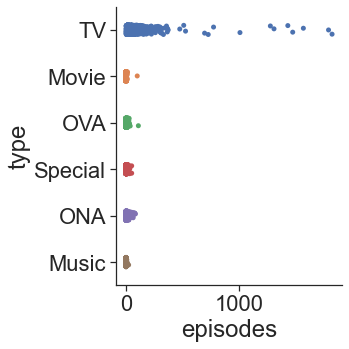

In [19]:
sns.catplot(x='episodes', y='type',data=anime_df)
sns.despine()

Okay, so we now know that there are 6 types of anime but the most common is TV.

Let's do another one to find out about these categories!

<AxesSubplot:xlabel='type', ylabel='count'>

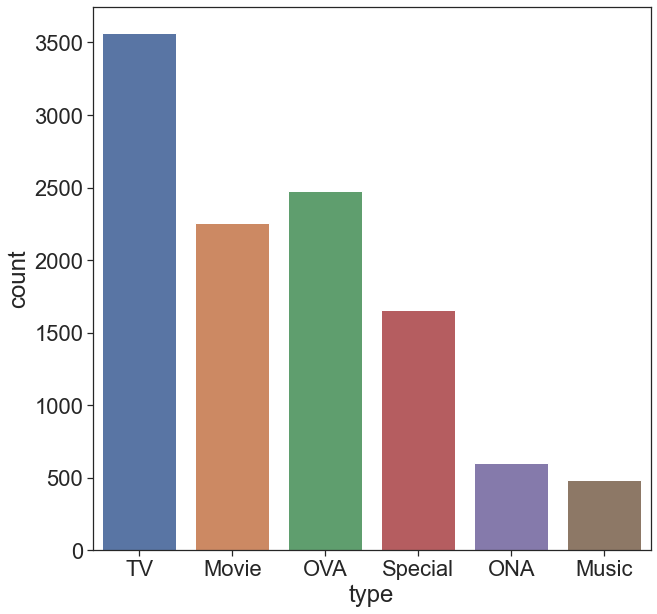

In [20]:
plt.figure(figsize=(10,10))
sns.countplot(x='type',data=anime_df)

Whoa! There's like 3500+ TV shows alone! That's surreal to think about...

**Fun Fact**: the Anime with the highest number of episodes according to this dataset is "Oyako Club", with 1818 episodes at the time of data retrieval! 

Next, let's see what the relationship between episode numbers and rating is.

<AxesSubplot:xlabel='episodes', ylabel='rating'>

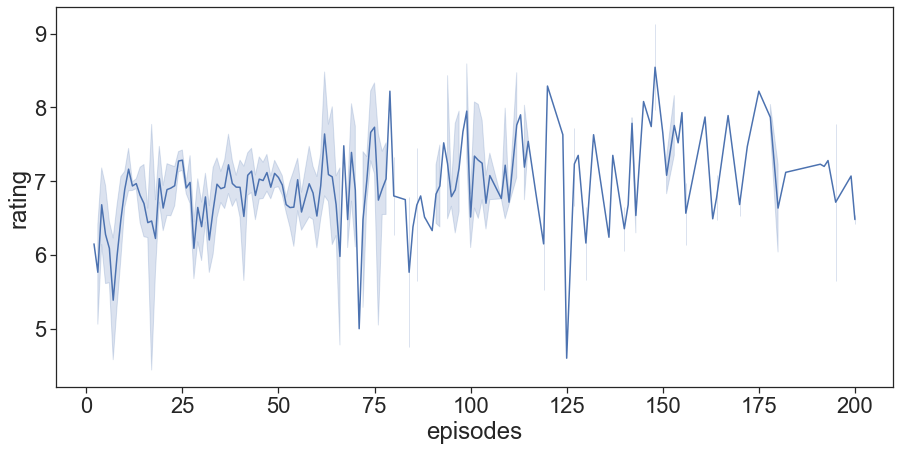

In [21]:
plt.figure(figsize=(15,7))
sns.lineplot(x='episodes', y='rating',data=anime_df.loc[((anime_df['episodes'] <= 200) & (anime_df['type'] == 'TV'))])

 This plot was limited to just TV series, since adding movies and specials might skew the plotting a little since their episode counts are usually very low, but let's try it out for Everything other than Movies or TV shows then!

<AxesSubplot:xlabel='episodes', ylabel='rating'>

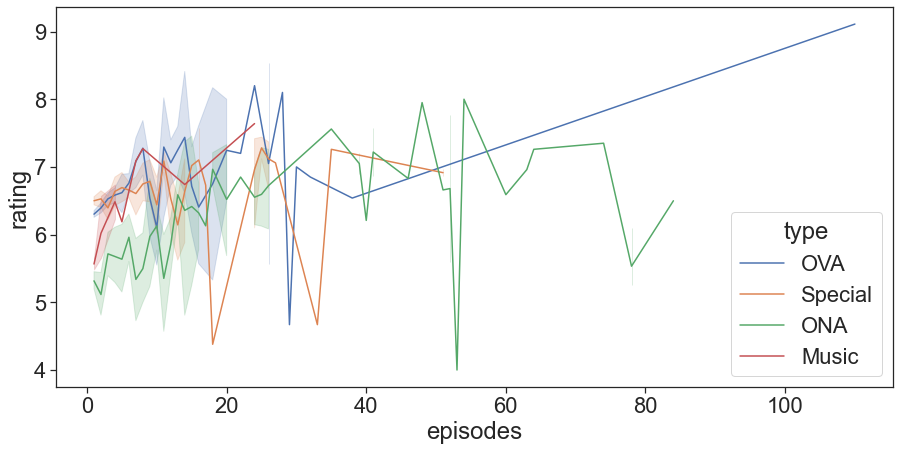

In [22]:
plt.figure(figsize=(15,7))
sns.lineplot(x='episodes', y='rating', hue= 'type',data=anime_df.loc[~((anime_df['type'] == 'Movie') | (anime_df['type'] == 'TV'))])

**Thoughts**: Well, there isn't anything too interesting other than the fact that the rating generally is higher for anime as the episode count goes up, but it isn't guaranteed.

### Ratings Database:

Okay here's where things get interesting (and slightly more complex). We know the average rating for each anime, but how about how users rated individual anime? Let's take a look at some basic stats.

Let's see the frequencies of each rating since they are all on a scale of 1 to 10:

<AxesSubplot:xlabel='rating', ylabel='count'>

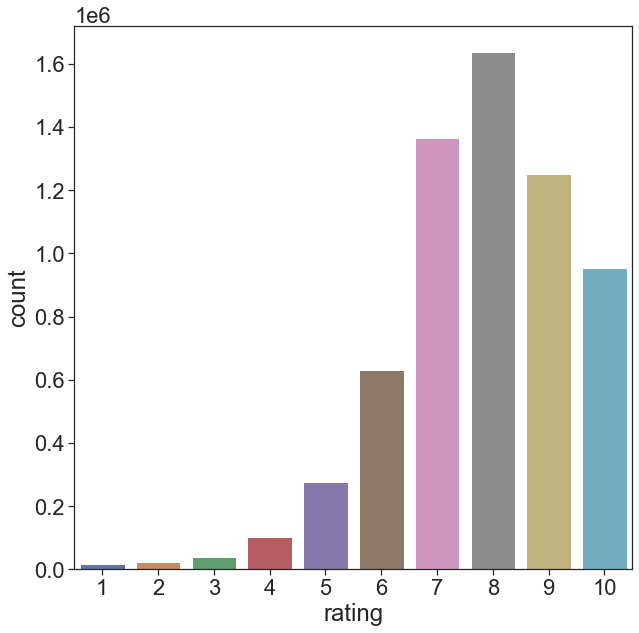

In [23]:
plt.figure(figsize=(10,10))
sns.countplot(x='rating',data=ratings_df)

Well, The highest occurring rating seems to be 8, so is the majority of anime an 8/10?

Okay, that seems pretty good for our EDA. Let's get on with our more in-depth analysis and answering our reasearch questions!

## Step 4: The *real* analysis

Let's take a look at our research questions then. For this analysis they are:

* **RQ 1**:  What genre of anime is popular amongst people that have seen very few anime vs. the genre that is popular among anime "veterans"?

Before we dive into our research question, we should do some general analysis to get a better idea of the aspects we will be looking for, so let's see how the rating is distributed for various anime. The following code will generate rating graphs for 4 randomly sampled anime and their user ratings. The y-axis represents the number of users that gave the anime a particular rating. Try it a few times to see how this ends up changing!

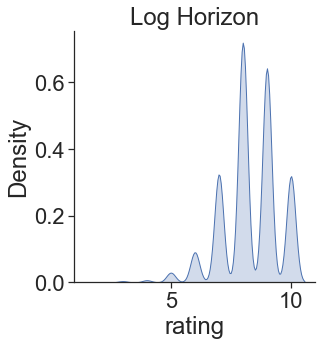

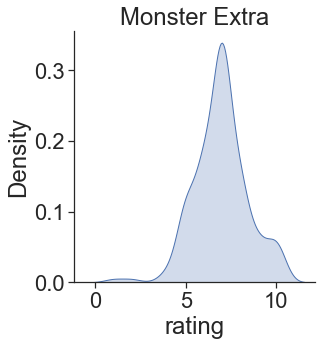

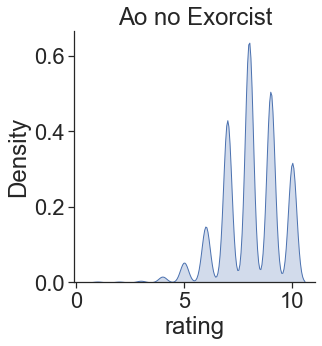

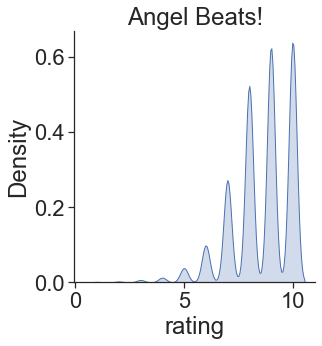

In [25]:
for x in range(1, 5):
    samp = ratings_df['anime_id'].sample().tolist()[0]
    sns.displot(x='rating',kind="kde",fill=True,data=ratings_df.loc[ratings_df['anime_id'] == samp])
    plt.title(anime_df.loc[anime_df['anime_id'] == samp]['name'].tolist()[0])


Next, let's try to generate a set of all the unique types of Genres that exist in our dataset

In [15]:
genre_list = anime_df['genre'].values
genre_set = set()
for g in genre_list:
    for it in g:
        genre_set.add(it.strip())
genre_set

{'Action',
 'Adventure',
 'Cars',
 'Comedy',
 'Dementia',
 'Demons',
 'Drama',
 'Ecchi',
 'Fantasy',
 'Game',
 'Harem',
 'Hentai',
 'Historical',
 'Horror',
 'Josei',
 'Kids',
 'Magic',
 'Martial Arts',
 'Mecha',
 'Military',
 'Music',
 'Mystery',
 'Parody',
 'Police',
 'Psychological',
 'Romance',
 'Samurai',
 'School',
 'Sci-Fi',
 'Seinen',
 'Shoujo',
 'Shoujo Ai',
 'Shounen',
 'Shounen Ai',
 'Slice of Life',
 'Space',
 'Sports',
 'Super Power',
 'Supernatural',
 'Thriller',
 'Vampire',
 'Yaoi',
 'Yuri'}

**Note**: We would usually use something like `anime_df.genre.unique()` to get all of the unique values in our dataset, but since we are dealing with a list of genres, we had to use a bespoke method that may not be as efficient as the `unique()` method.

Okay so this is the list of all unique genres in our dataset, and the `genre` column in our dataframe is any combination of these values.

Now let's dive into answering our research question!

### **RQ 1**:  What genre of anime is popular amongst people that have seen very few anime vs. the genre that is popular among anime "veterans"?

To answer this one we need to know the distribution of how many anime each user has ended up watching. Let's make a smaller dataframe with a column for the user_id and a column for number of anime watched.

In [27]:
usercount_df = ratings_df['user_id'].value_counts().rename_axis('user_id').to_frame('anime_watched').sort_values('user_id', ascending = True).reset_index()
usercount_df

,user_id,anime_watched
0,1,4
1,2,1
2,3,92
3,5,459
4,7,343
...,...,...
69570,73512,12
69571,73513,33
69572,73514,1
69573,73515,179


Now we have a dataframe, let's do some calculations to see the basic statistics of thenumber of anime users have watched.

In [30]:
usercount_df.describe().drop(columns=['user_id']).T

,count,mean,std,min,25%,50%,75%,max
anime_watched,69575.0,90.4659,133.88416,1.0,13.0,44.0,114.0,3635.0


Hmm, so let's do an even split, and call people that have seen at least 44 anime (a 50% split), to do that let's add a column that specifies if they're a veteran or not.

In [31]:
usercount_df['veteran'] = usercount_df['anime_watched'] >= 44

In [32]:
usercount_df.head()

,user_id,anime_watched,veteran
0,1,4,False
1,2,1,False
2,3,92,True
3,5,459,True
4,7,343,True


In [33]:
usercount_df['veteran'].value_counts()

True     35155
False    34420
Name: veteran, dtype: int64

That seemed to divide our user base almost evenly so let's go with this. 

Now that we know who is a veteran and who isn't, let's try to see what genre a veteran might enjoy the most. Since the genre column usually has a list of multiple anime genres, let's assume that for our purposes, the **first element of the list is the main genre, and the second is the sub-genre, while the others are secondary genres**. This will allow us to focus our analysis since there is a whole argument about whether an anime should be long to just one major genre, or all of it's subgenres as well. 

To achieve this, and reduce confusion let's make two new columns on our anime dataset, called `genre_1` and `genre_2` which specify the main and sub-genre respectively.

In [34]:
anime_df['genre_1'] = anime_df['genre'].values
anime_df['genre_1'] = anime_df['genre_1'].apply(lambda x: x[0].strip())
anime_df['genre_2'] = anime_df['genre'].values
anime_df['genre_2'] = anime_df['genre_2'].apply(lambda x: x + ['None']).apply(lambda x: x[1].strip())
anime_df = anime_df.drop(columns='genre')
anime_df

,anime_id,name,type,episodes,rating,genre_1,genre_2
0,1,Cowboy Bebop,TV,26,8.82,Sci-Fi,Action
1,5,Cowboy Bebop: Tengoku no Tobira,Movie,1,8.40,Mystery,Space
2,6,Trigun,TV,26,8.32,Comedy,Sci-Fi
3,7,Witch Hunter Robin,TV,26,7.36,Magic,Action
4,8,Beet the Vandel Buster,TV,52,7.06,Supernatural,Fantasy
...,...,...,...,...,...,...,...
11040,34476,Platonic Chain: Ansatsu Jikkouchuu,Special,1,1.67,Sci-Fi,Slice of Life
11041,34490,Sushi Azarashi,TV,30,3.00,Comedy,None
11042,34503,Kochinpa! Dainiki,TV,24,3.40,Comedy,None
11043,34514,Pokemon Generations,ONA,18,7.21,Kids,Adventure


Looking good! Now let's visualize what a user's pereference for certain genres is like!

The following code will take a slice of our user data frame and add a new column called `fav` that corresponds to that user's most watched anime. 

In [35]:
def getGen(x):
    #Function that queries the anime database and gets the primary genre by anime_id
    return anime_df[anime_df.anime_id == x['anime_id']]['genre_1'].item()

def getindidata(user_id):
    #Returns a dataframe slice that has the rating info with genre of anime attached for a user with user_id
    df = ratings_df.loc[ratings_df['user_id'] == user_id]
    df['genre'] = df.apply(getGen,axis = 1)
    return df

In [36]:
def favGenre(x):
    #Return the favourite/most watched genre for a single user
    user_id = x['user_id']
    df = getindidata(user_id)
    return df['genre'].value_counts().rename_axis('genre').to_frame('watched').reset_index().iloc[0]['genre']   


#### Warning!! The following cell will take a while to calculate since there's a lot of methods being chained at once, so please give it some time!

In [37]:
vet_df = usercount_df.loc[usercount_df['veteran'] == True].sample(n=500) #Select 500 random veteran anime watchers
vet_df['fav'] = vet_df.apply(favGenre,axis = 1)
vet_df

,user_id,anime_watched,veteran,fav
12515,13235,169,True,Comedy
51546,54468,117,True,Action
332,354,86,True,Comedy
65007,68648,212,True,Comedy
21266,22515,81,True,Fantasy
...,...,...,...,...
7432,7846,320,True,Action
43278,45820,704,True,Comedy
22307,23601,150,True,Comedy
65533,69215,78,True,Comedy


The cell above only takes a small portion of the data to verify our result. The sample size is adjustable by changing the value of upper limit `n` on the `.sample()` function, but requires more time and more processing power. I've found 500 is a decent sample size that tells us what we need to know.

Now, we are finally armed to answer our research question! Let's see for ourselves what is the anime veteran's favourite anime genre!

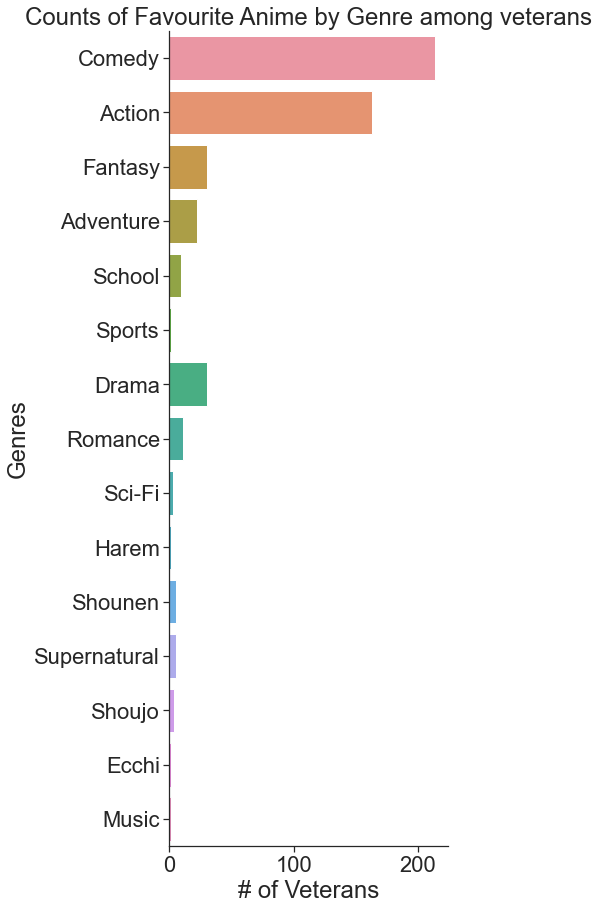

In [38]:
plt.figure(figsize = (5, 15))
sns.countplot(y='fav', data = vet_df)
plt.title(label="Counts of Favourite Anime by Genre among veterans")
plt.ylabel('Genres')
plt.xlabel('# of Veterans')
sns.despine()

**NOTE**: Since the code samples a random set of veterans, your results may be different. So here is what I ended up with in my random selection:

![VeteranFavGenre](../images/vetgraph.png)

Well, it seems my set of chosen veterans have quite the sense of humour, since they recommend anime with the 'Comedy' genre!

Since we know their opinion, let's see what the non-veterans think!

In [39]:
newbie_df = usercount_df.loc[usercount_df['veteran'] == False].sample(n=500) #Select 500 random newbie anime watchers
newbie_df['fav'] = newbie_df.apply(favGenre,axis = 1)
newbie_df

,user_id,anime_watched,veteran,fav
2196,2339,7,False,Hentai
40032,42385,41,False,Fantasy
49245,52064,13,False,Drama
47043,49778,26,False,Comedy
9699,10251,22,False,Comedy
...,...,...,...,...
41768,44237,11,False,Psychological
48272,51050,2,False,Action
34756,36775,40,False,Comedy
56159,59303,3,False,Romance


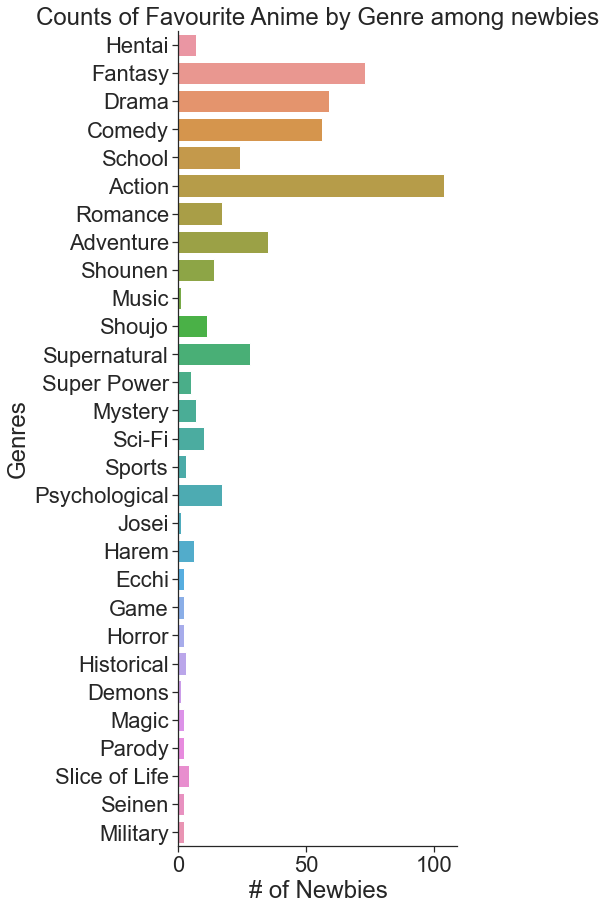

In [40]:
plt.figure(figsize = (5, 15))
sns.countplot(y='fav', data = newbie_df)
plt.title(label="Counts of Favourite Anime by Genre among newbies")
plt.ylabel('Genres')
plt.xlabel('# of Newbies')
sns.despine()

Again, it might take a while to process and the result might be different, but here is my result:


![NewbFavGenre](../images/newbgraph.png)

My set of Newbies seemed to like Action shows! 

#### Results & Findings for RQ 1:

* So veterans liked 'Comedy' anime, and newbies enjoyed 'Action' anime. This is actually something I hypothesized, since most newbies end up watching aime due to the flashy action that has become mainstream in the industry. While on the other hand, veterans enjoy comedy, which isn't necessarily a popular genre in anime, atleast an anime that is mainly comedy. It makes sense that veterans would enjoy genres that one encounters only once they are deeper into the industry, so there isn't too much of a surprise there.
* Since this analysis required quite a bit of estimation and variability, your results might differ from this, so try to see if you can see different patterns!

---

And that should do it for our analysis! It was truly enlightening to see how relationships between huge masses of data like this dataset work. I limited the number of research questions to 1 since this was a solo project, so if I had a group maybe we could have explored the topic in different ways! 

Thank you for coming with me on this analytical journey! :)

But before we wrap up here, how about we save our processed dataframes into `.csv` files so we can use it in our Tableau Dashboard! 

Again, the `ratings_df` is very large so it will take a second to convert.

In [42]:
anime_df.to_csv('../data/processed/anime.csv',index=False)
ratings_df.to_csv('../data/processed/ratings.csv',index=False)
usercount_df.to_csv('../data/processed/usercount.csv',index=False)

Okay that should do it!

---